# Identifying temporal variation in EvoDevo data with MEFISTO

This notebook demonstrates how temporal (or spatial) covariates can be used for multimodal data integration to learn smooth latent factors using a developmental gene expression atlas comprising multiple species and organs.

Please find more information about this method — *MEFISTO* — [on its website](https://biofam.github.io/MOFA2/MEFISTO) and [in the preprint](https://www.biorxiv.org/content/10.1101/2020.11.03.366674v1) by Britta Velten et al.

A R version of the tutorial is available [here](https://raw.githack.com/bioFAM/MEFISTO_tutorials/master/evodevo_tutorial.html).

In [1]:
import numpy as np
import pandas as pd
from mofapy2.run.entry_point import entry_point
import mofax
import seaborn as sns

# initialise the entry point
ent = entry_point()


        #########################################################
        ###           __  __  ____  ______                    ### 
        ###          |  \/  |/ __ \|  ____/\    _             ### 
        ###          | \  / | |  | | |__ /  \ _| |_           ### 
        ###          | |\/| | |  | |  __/ /\ \_   _|          ###
        ###          | |  | | |__| | | / ____ \|_|            ###
        ###          |_|  |_|\____/|_|/_/    \_\              ###
        ###                                                   ### 
        ######################################################### 
       
 
        


## Load data

First we will load the evodevo data containing normalized gene expression data for 5 species (groups) and 5 organs (views) as well as the developmental time information for each sample. The data as well as a pre-trained model can be downloaded [from here](https://figshare.com/s/242916198fde3353f3e6).

In [2]:
datadir = "data/evodevo"

In [3]:
data = pd.read_csv(f"{datadir}/evodevo.csv", sep=",", index_col=0)
data

,group,view,sample,feature,value,time
1,Human,Brain,10wpc_Human,ENSG00000000457_Brain,8.573918,7
2,Human,Brain,10wpc_Human,ENSG00000001084_Brain,8.875957,7
3,Human,Brain,10wpc_Human,ENSG00000001167_Brain,11.265237,7
4,Human,Brain,10wpc_Human,ENSG00000001461_Brain,7.374965,7
5,Human,Brain,10wpc_Human,ENSG00000001561_Brain,7.311018,7
...,...,...,...,...,...,...
3193836,Human,Testis,youngMidAge_Human,ENSG00000271503_Testis,1.178014,21
3193837,Human,Testis,youngMidAge_Human,ENSG00000271601_Testis,1.178014,21
3193838,Human,Testis,youngMidAge_Human,ENSG00000272442_Testis,4.476201,21
3193839,Human,Testis,youngMidAge_Human,ENSG00000272886_Testis,1.178014,21


## Prepare and train MEFISTO

Next we create a MOFA object with this data with the default options.

In [4]:
ent.set_data_options()
ent.set_data_df(data)



Loaded group='Human' view='Brain' with N=23 samples and D=7696 features...
Loaded group='Human' view='Cerebellum' with N=23 samples and D=7696 features...
Loaded group='Human' view='Heart' with N=23 samples and D=7696 features...
Loaded group='Human' view='Liver' with N=23 samples and D=7696 features...
Loaded group='Human' view='Testis' with N=23 samples and D=7696 features...
Loaded group='Mouse' view='Brain' with N=14 samples and D=7696 features...
Loaded group='Mouse' view='Cerebellum' with N=14 samples and D=7696 features...
Loaded group='Mouse' view='Heart' with N=14 samples and D=7696 features...
Loaded group='Mouse' view='Liver' with N=14 samples and D=7696 features...
Loaded group='Mouse' view='Testis' with N=14 samples and D=7696 features...
Loaded group='Opossum' view='Brain' with N=15 samples and D=7696 features...
Loaded group='Opossum' view='Cerebellum' with N=15 samples and D=7696 features...
Loaded group='Opossum' view='Heart' with N=15 samples and D=7696 features...


We can now specify additional option for the model and the training. See our [basic python tutorial on MOFA](https://github.com/bioFAM/mofapy2/blob/master/mofapy2/notebooks/getting_started_python.ipynb)  for details. Here we specify, that we want to use 5 factor.

In [5]:
ent.set_model_options(factors=5)
ent.set_train_options()


Model options:
- Automatic Relevance Determination prior on the factors: False
- Automatic Relevance Determination prior on the weights: True
- Spike-and-slab prior on the factors: False
- Spike-and-slab prior on the weights: True
Likelihoods:
- View 0 (Brain): gaussian
- View 1 (Cerebellum): gaussian
- View 2 (Heart): gaussian
- View 3 (Liver): gaussian
- View 4 (Testis): gaussian




So far, we have not yet added the time information for the samples. This is done in the next step, where we also specify options for MEFISTO. In particular, we want to align time points between species and set `warp` to True using Mouse as reference. To also infer relationships between species we set `model_groups` to True.

In [6]:
times = [data[['sample', 'time', 'group']].drop_duplicates().set_index('sample').loc[np.concatenate(ent.data_opts['samples_names'])].query('group == @g').time.values.reshape(-1, 1) for g in ent.data_opts['groups_names']]
idx = np.where(ent.data_opts['groups_names'] == 'Mouse')

In [7]:
idx = ent.data_opts['groups_names'].index("Mouse")

In [8]:
ent.set_covariates(times, covariates_names="time")
ent.set_smooth_options(warping=True, warping_ref = idx, model_groups = True)

Loaded 1 covariate(s) for each sample...


##
## Warping set to True: aligning the covariates across groups
##


Now we are ready to use MEFISTO with this object and save the results in a speciefied location. As this can take up to 15min, we provide a pre-trained model below.

In [9]:
ent.build()
# ent.run()
# ent.save("evodevo_model.hdf5")

## Downstream analysis

For downstream analysis we can either use R (package [MOFA2](https://github.com/bioFAM/MOFA2)) or the Python package [mofax](https://github.com/gtca/mofax). Here we will proceed in Python and first load the pre-trained model generated by the above steps.

In [10]:
m = mofax.mofa_model(f"{datadir}/evodevo_model.hdf5")

In [11]:
print(f"""\
Samples: {m.shape[0]}
Features: {m.shape[1]}
Species: {', '.join(m.groups)}
Organs: {', '.join(m.views)}
""")

Samples: 83
Features: 38480
Species: Human, Mouse, Opossum, Rabbit, Rat
Organs: Brain, Cerebellum, Heart, Liver, Testis



### Variance explained

First, we can take a look at the variance explained by each of the inferred factors per organ and species.

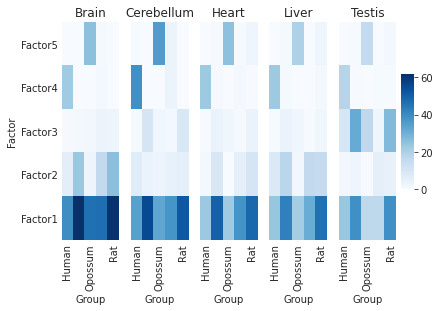

In [12]:
mofax.plot_r2(m, cmap="Blues")

### Visualization in the factor space

Using the first two factors, we can project the samples into a 2-dimensional space.

<AxesSubplot:title={'center':'group'}, xlabel='Factor1 value', ylabel='Factor2 value'>

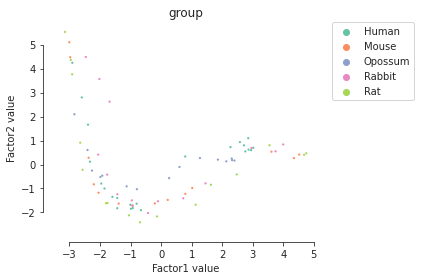

In [13]:
mofax.plot_factors_scatter(m, x=0, y=1)

## Latent factors versus common developmental time

We can plot the latent processes along the inferred common developmental time.

In [14]:
factors = m.get_factors()
times_learnt = np.concatenate([np.array(m.model['cov_samples_transformed'][g]) for g in m.groups])
times_before = np.concatenate([np.array(m.model['cov_samples'][g]) for g in m.groups])

In [15]:
samples = np.concatenate([m.samples[i] for i in m.samples.keys()])

In [16]:
m.groups

['Human', 'Mouse', 'Opossum', 'Rabbit', 'Rat']

In [17]:
df = pd.DataFrame(factors)
df.columns = ["Factor_%s" % i for i in df.columns]
df.index = samples
df['times_learnt'] = times_learnt
df['times_before'] = times_before
df["species"] = [s.split("_")[1] for s in df.index.values]
df

,Factor_0,Factor_1,Factor_2,Factor_3,Factor_4,times_learnt,times_before,species
10wpc_Human,-1.593744,-1.351432,-0.117982,-2.379145,0.248318,7.0,7.0,Human
11wpc_Human,-1.436093,-1.397599,-0.020983,-2.029883,0.176616,7.0,8.0,Human
12wpc_Human,-1.433808,-1.822555,0.182214,-3.191192,0.581367,9.0,9.0,Human
13wpc_Human,-0.986568,-1.844258,0.355141,-2.173261,0.370851,9.0,10.0,Human
16wpc_Human,-0.926743,-1.816859,0.713284,-2.251459,0.514470,9.0,11.0,Human
...,...,...,...,...,...,...,...,...
P112_Rat,4.753750,0.466889,-3.232960,-0.512885,-0.883466,14.0,16.0,Rat
P14_Rat,3.549837,0.805237,1.787815,-0.559222,-0.710352,12.0,14.0,Rat
P3_Rat,1.631693,-0.844507,2.203644,-0.654158,-0.444942,11.0,12.0,Rat
P42_Rat,4.679887,0.407634,-3.140164,-0.489651,-0.901785,14.0,15.0,Rat


Before alignment:

<AxesSubplot:xlabel='times_before', ylabel='Factor_0'>

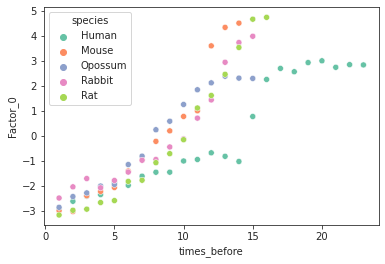

In [18]:
sns.scatterplot(x="times_before", y="Factor_0",
                hue="species", data = df)

After alignment:

<AxesSubplot:xlabel='times_learnt', ylabel='Factor_0'>

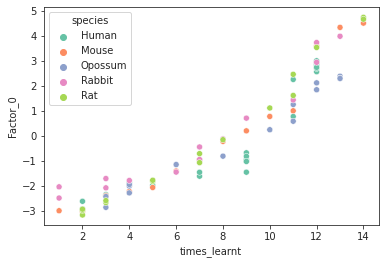

In [19]:
sns.scatterplot(x="times_learnt", y="Factor_0",
                hue="species", data = df)

## Alignment

We can also take a look at the learnt alignemnt.

<AxesSubplot:xlabel='times_before', ylabel='times_learnt'>

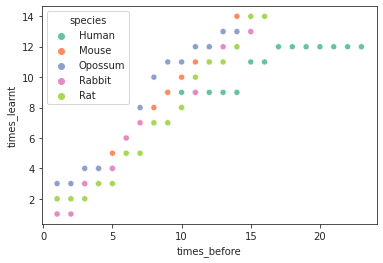

In [20]:
sns.scatterplot(x="times_before", y="times_learnt",
                hue="species", data = df)

### Weights

To gain insights into the molecular signatures underlying each factor, we can investigate the weights of each factor.

<AxesSubplot:title={'center':'Brain'}, xlabel='factor', ylabel='feature'>

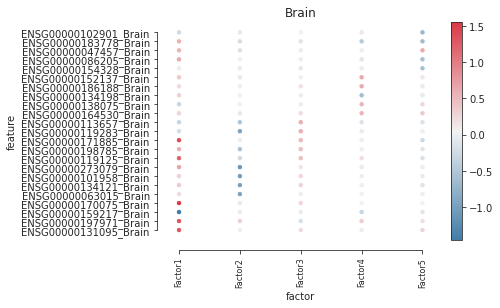

In [21]:
mofax.plot_weights_dotplot(m, view = "Brain", yticklabels_size=10)

<AxesSubplot:title={'center':'Testis'}, xlabel='factor', ylabel='feature'>

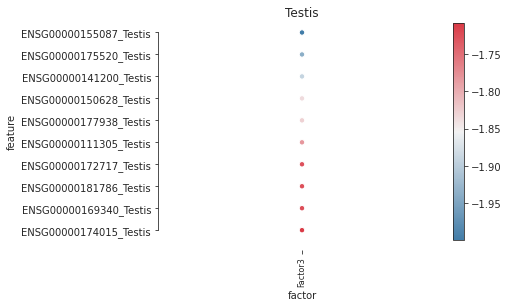

In [22]:
mofax.plot_weights_dotplot(m, view = "Testis", factors = 2, n_features = 10, yticklabels_size=10)

## Further analyses

Further down-stream analyses can be found in our [R tutorial](https://raw.githack.com/bioFAM/MEFISTO_tutorials/master/evodevo_tutorial.html) (e.g. interpolation, smoothness inspection, gene set enrichment analysis or inspection of group relationships and sharedness) and of course custom analysis can be performed using the inferred weights and factors.